In [1]:
import sys
sys.path.append('..')

import os
import cv2
import json
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
from matplotlib.patches import Circle
from matplotlib.colorbar import ColorbarBase
from matplotlib.collections import PatchCollection
from matplotlib.colors import LinearSegmentedColormap, Normalize

from src.config.config import RENDER_FOLDER_PATH

HEATMAP_WIDTH = 100
HEATMAP_HEIGHT = 100

✅ Running with random seed: 2375914143.


In [8]:
def crop_image(image, bb_x, bb_y, bb_width, bb_height):
    return image[
        int(bb_y - bb_height / 2) : int(bb_y + bb_height / 2),
        int(bb_x - bb_width / 2) : int(bb_x + bb_width / 2),
    ]


def show_led_locations(render_folder_name, frame_number):
    render_folder_path = os.path.join(RENDER_FOLDER_PATH, render_folder_name)
    if not os.path.isdir(render_folder_path):
        raise FileNotFoundError(f"❌ Render folder {render_folder_path} not found.")
    bg_frame_file_path = os.path.join(
        render_folder_path, f"bg", f"{frame_number:04}.png"
    )
    if not os.path.isfile(bg_frame_file_path):
        raise FileNotFoundError(f"❌ Frame file {bg_frame_file_path} not found.")
    no_bg_frame_file_path = os.path.join(
        render_folder_path, f"no-bg", f"{frame_number:04}.png"
    )
    if not os.path.isfile(no_bg_frame_file_path):
        raise FileNotFoundError(f"❌ Frame file {no_bg_frame_file_path} not found.")
    segmentation_file_path = os.path.join(
        render_folder_path, "segmentation", f"{frame_number:04}.png"
    )
    if not os.path.isfile(segmentation_file_path):
        raise FileNotFoundError(
            f"❌ Segmentation file {segmentation_file_path} not found."
        )
    data_file_path = os.path.join(render_folder_path, f"data.json")
    if not os.path.isfile(data_file_path):
        raise FileNotFoundError(f"❌ Data file {data_file_path} not found.")

    bg_frame_image = cv2.imread(bg_frame_file_path)
    bg_frame_image_width = bg_frame_image.shape[1]
    bg_frame_image_height = bg_frame_image.shape[0]
    patches_occlusion = []
    patches_relative_orientation = []
    with open(data_file_path, "r") as f:
        data = json.load(f)[str(frame_number)]
        leds_data = data["leds"]
        for _, led_data in leds_data.items():
            x = int(led_data["u"] * bg_frame_image_width)
            y = int((1 - led_data["v"]) * bg_frame_image_height)
            is_occluded = bool(led_data["is_occluded"])
            is_in_frame = bool(led_data["is_in_frame"])
            led_relative_orientation = (led_data["led_relative_orientation"] + 1) / 2

            if not is_in_frame:
                continue

            color_occlusion = (
                (1, 0, 0, 0.3) if is_occluded else (0, 1, 0, 0.3)
            )  # RGBA color with alpha
            color_relative_orientation = (
                0,
                led_relative_orientation,
                1 - led_relative_orientation,
                0.3,
            )  # RGBA color with alpha

            # Create circles
            circle_occlusion = Circle((x, y), radius=2, color=color_occlusion)
            circle_relative_orientation = Circle(
                (x, y), radius=2, color=color_relative_orientation
            )

            # Append to patch lists
            patches_occlusion.append(circle_occlusion)
            patches_relative_orientation.append(circle_relative_orientation)

        # Get bounding box
        bb_data = data["bounding_box"]
        if bb_data is not None:
            bb_center = bb_data["center"]
            bb_x = bb_center["u"] * bg_frame_image_width
            bb_y = (1 - bb_center["v"]) * bg_frame_image_height
            bb_width = bb_data["width"] * bg_frame_image_width
            bb_height = bb_data["height"] * bg_frame_image_height

    # Get Segmentation mixed with bg image
    segmentation_image = cv2.imread(segmentation_file_path)
    segmentation_image[:, :, [0, 2]] = 0  # set blue mask from rgb
    # set green mask from rgb
    segmentation_image = cv2.addWeighted(
        bg_frame_image, 0.5, segmentation_image, 0.5, 0
    )

    # Create PatchCollections
    pc_occlusion = PatchCollection(patches_occlusion, match_original=True)
    pc_relative_orientation = PatchCollection(
        patches_relative_orientation, match_original=True
    )

    # Get ground truth image cropped to bounding box
    no_bg_frame_image = cv2.imread(no_bg_frame_file_path)
    if bb_data is not None:
        no_bg_frame_image = crop_image(
            no_bg_frame_image, bb_x, bb_y, bb_width, bb_height
        )

    # Plotting
    plt.figure(figsize=(24, 12))

    plt.subplot(2, 3, 1)
    plt.imshow(cv2.cvtColor(bg_frame_image, cv2.COLOR_BGR2RGB))
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(2, 3, 2)
    plt.imshow(cv2.cvtColor(bg_frame_image, cv2.COLOR_BGR2RGB))
    plt.title("Input Image with Occludeed LEDs")
    plt.axis("off")
    plt.gca().add_collection(pc_occlusion)
    plt.gca().add_patch(
        Circle((0, 0), radius=0, color=(1, 0, 0, 0.5), label="Occluded LED")
    )
    plt.gca().add_patch(
        Circle((0, 0), radius=0, color=(0, 1, 0, 0.5), label="Visible LED")
    )
    plt.legend()

    plt.subplot(2, 3, 3)
    plt.imshow(cv2.cvtColor(bg_frame_image, cv2.COLOR_BGR2RGB))
    plt.title("Input Image with LEDs Relative Orientation")
    plt.axis("off")
    plt.gca().add_collection(pc_relative_orientation)
    plt.gca().add_patch(
        Circle(
            (0, 0),
            radius=0,
            color=(0, 0, 1, 0.5),
            label="LED Relative Orientation",
        )
    )
    # Padding for colorbar
    plt.gca().add_patch(
        Circle(
            (0, 0),
            radius=0,
            color=(0, 0, 0, 0),
            label=" ",
        )
    )
    plt.gca().add_patch(
        Circle(
            (0, 0),
            radius=0,
            color=(0, 0, 0, 0),
            label=" ",
        )
    )
    plt.legend()
    cmap = LinearSegmentedColormap.from_list("custom_cmap", [(0, "blue"), (1, "green")])
    norm = Normalize(vmin=-1, vmax=1)
    cbar_ax = plt.gcf().add_axes([0.91, 0.895, 0.05, 0.0075])
    ColorbarBase(cbar_ax, cmap=cmap, norm=norm, orientation="horizontal")
    cbar_ax.set_label("Relative Orientation")

    plt.subplot(2, 3, 4)
    plt.imshow(segmentation_image)
    plt.title("Device Bounding Box and Segmentation Mask")
    plt.axis("off")
    if bb_data is not None:
        plt.gca().add_patch(
            plt.Rectangle(
                (bb_x - bb_width / 2, bb_y - bb_height / 2),
                bb_width,
                bb_height,
                fill=False,
                color="red",
                linewidth=1,
                label="Device Bounding Box",
            )
        )
    plt.gca().add_patch(
        Circle((0, 0), radius=0, color=(0, 1, 0, 0.5), label="Device Segmentation Mask")
    )
    plt.legend()

    plt.subplot(2, 3, 5)
    plt.imshow(cv2.cvtColor(no_bg_frame_image, cv2.COLOR_BGR2RGB))
    plt.title("Ground Truth Image (Cropped to Bounding Box)")
    plt.axis("off")

    plt.suptitle(f"Frame number {frame_number} of render {render_folder_name}", fontsize=24)
    plt.tight_layout()
    plt.show()

/tmp/ipykernel_172418/891906643.py:186: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


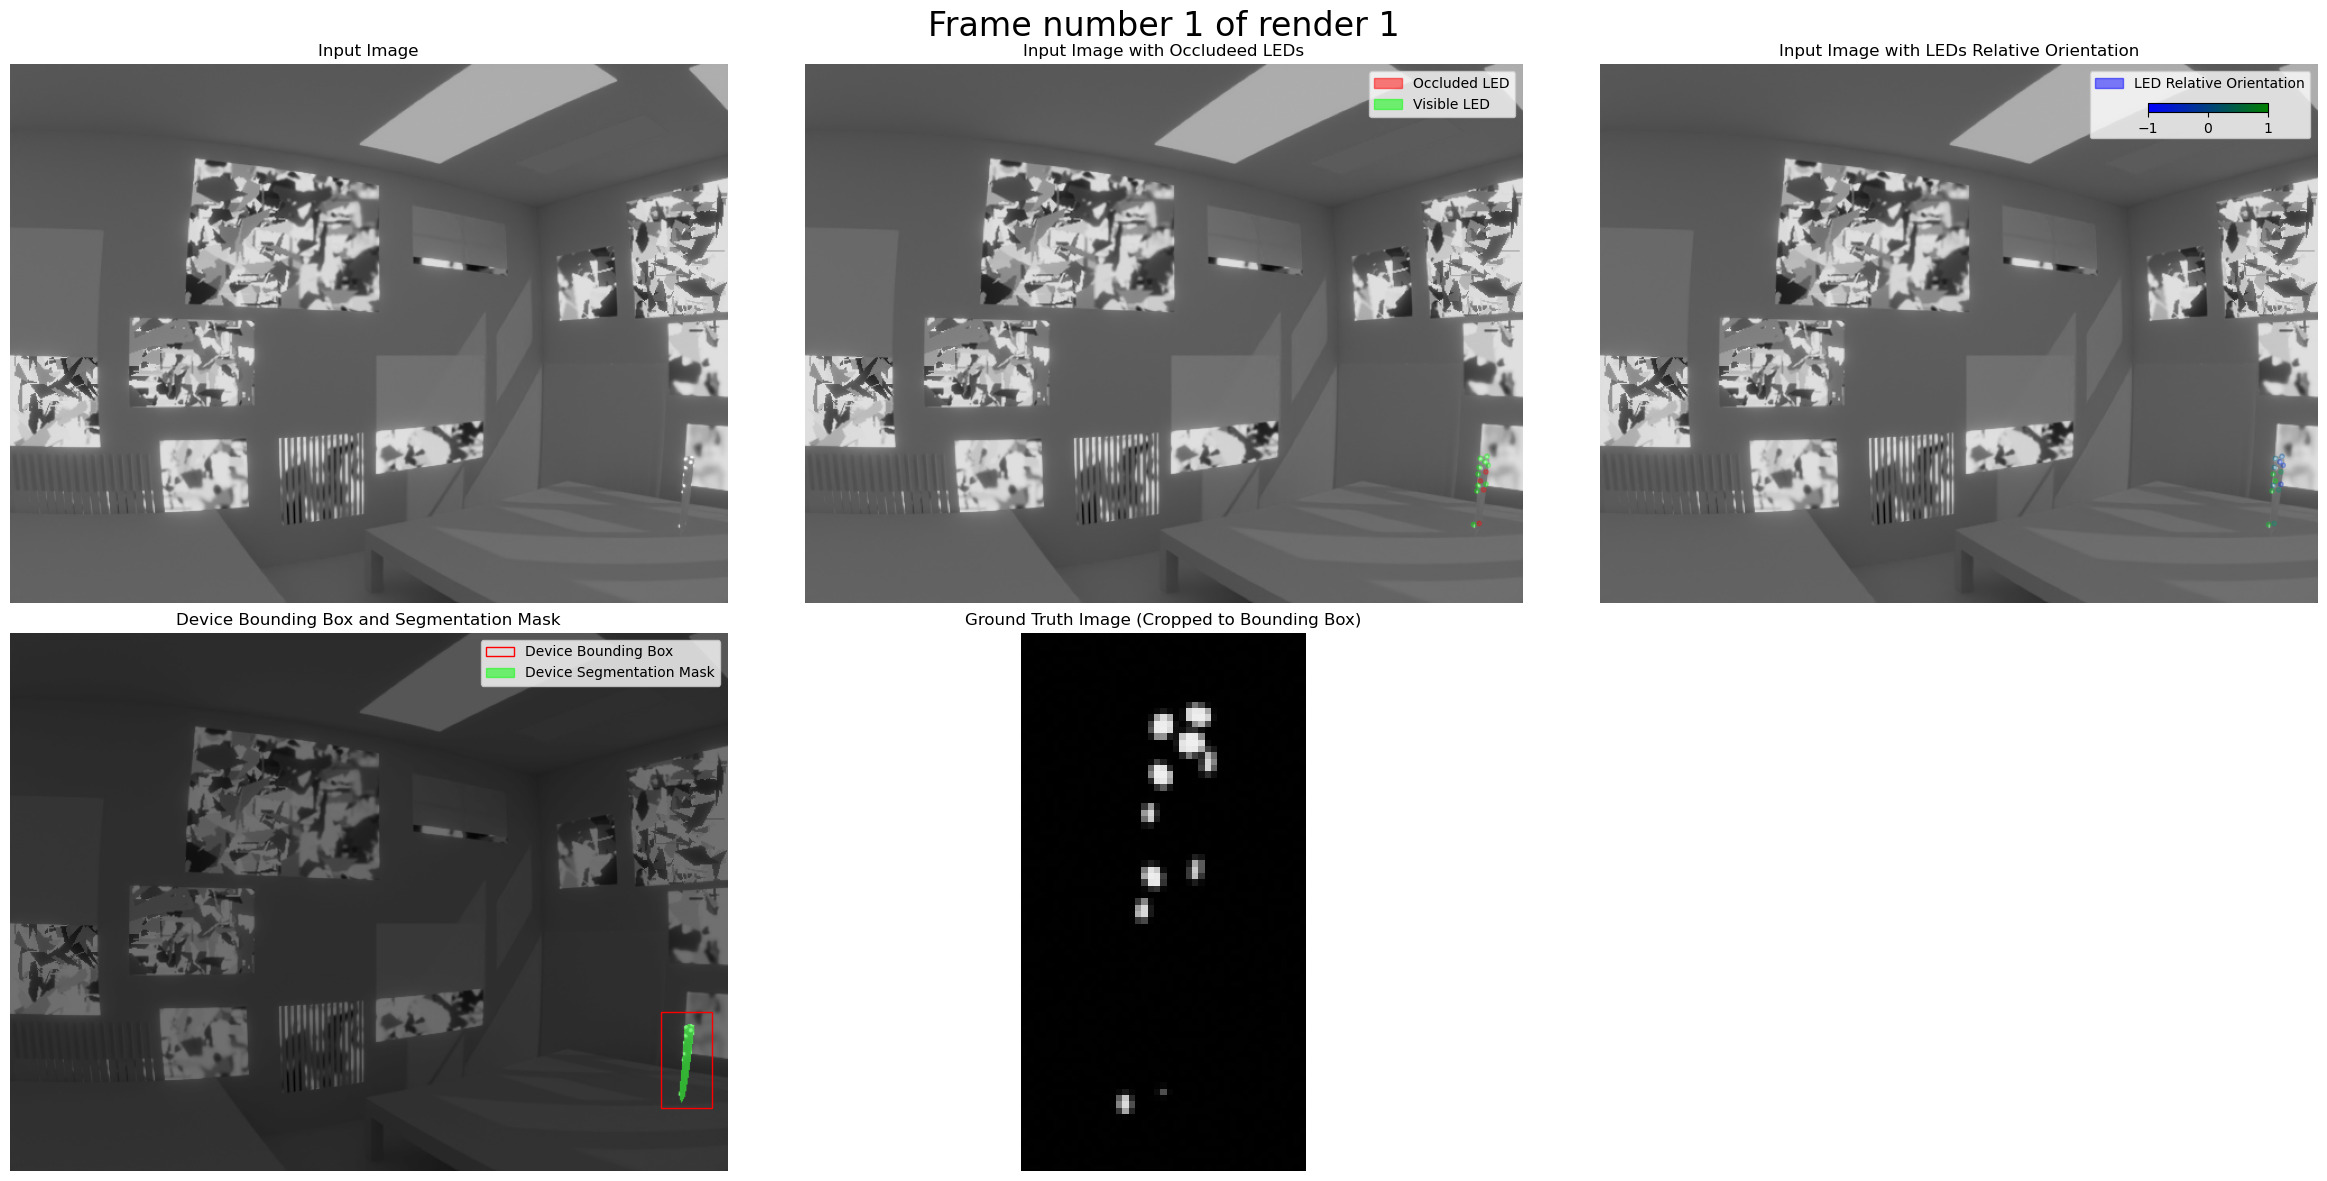

In [9]:
show_led_locations("1", 1)

In [10]:
def data_iterator(show_progress: bool = False):
    """
    Iterates over all data files in the render folder path and yields the data in each file.
    
    Args:
        show_progress: Whether to show a progress bar.
        
    Yields:
        dict: The data in each data file.
    """
    render_folder_paths = os.listdir(RENDER_FOLDER_PATH)

    if show_progress:
        bar = tqdm(render_folder_paths, total=len(render_folder_paths), desc="Iterating over render folders")

    for render_folder_path in render_folder_paths:
        data_file_path = os.path.join(RENDER_FOLDER_PATH, render_folder_path, "data.json")

        if not os.path.exists(data_file_path):
            print(f"Data file not found for render folder {render_folder_path}.")
            continue

        with open(data_file_path, "r") as f:
            data = json.load(f)
            yield data

        if show_progress:
            bar.update(1)

    if show_progress:
        bar.close()

def frame_data_iterator(show_progress: bool = False):
    """
    Iterates over all frame data in the data files and yields the frame data in each file.
    
    Args:
        show_progress: Whether to show a progress bar.
        
    Yields:
        dict: The frame data in each data file.
    """
    for data in data_iterator(show_progress=show_progress):
        for frame_data in data.values():
            yield frame_data

def led_data_iterator(show_progress=False):
    """
    Iterates over all LED data in the frame data and yields the LED data in each frame.
    
    Args:
        show_progress: Whether to show a progress bar.
        
    Yields:
        dict: The LED data in each frame.
    """
    for frame_data in frame_data_iterator(show_progress=show_progress):
        stylus_relative_orientation = frame_data["stylus_relative_orientation"]
        for led_data in frame_data["leds"].values():
            led_data["stylus_relative_orientation"] = stylus_relative_orientation
            yield led_data

Iterating over render folders:   0%|          | 0/288 [00:00<?, ?it/s]

Iterating over render folders: 100%|██████████| 288/288 [00:03<00:00, 93.70it/s]


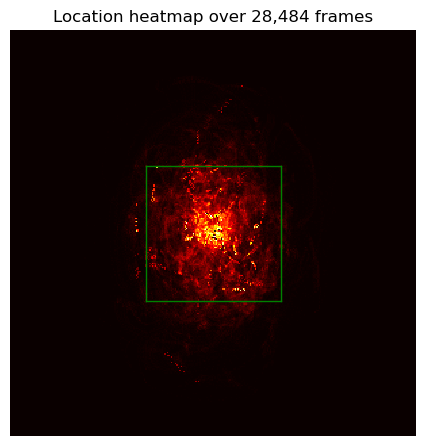

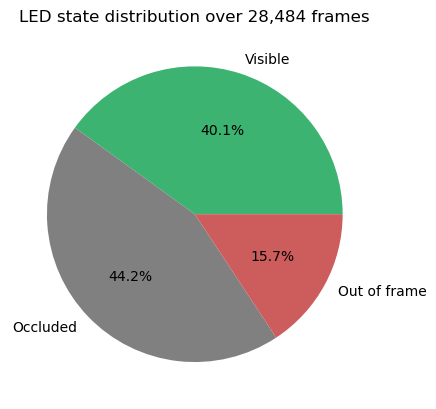

In [11]:
out_of_frame_margins = 1
location_heatmap = np.zeros((HEATMAP_WIDTH * (1 + 2 * out_of_frame_margins), HEATMAP_HEIGHT * (1 + 2 * out_of_frame_margins)), dtype=np.uint8)
n_visible_leds = 0
n_occluded_leds = 0
n_out_of_frame_leds = 0
n_total_leds = 0
n_frames = 0
for led_data in led_data_iterator(show_progress=True):
    u = led_data["u"]
    v = led_data["v"]
    x = int(led_data["u"] * HEATMAP_WIDTH) + HEATMAP_WIDTH * out_of_frame_margins
    y = int(led_data["v"] * HEATMAP_HEIGHT) + HEATMAP_HEIGHT * out_of_frame_margins
    is_occluded = led_data["is_occluded"]
    is_in_frame = bool(led_data["is_in_frame"])

    out_of_heatmap_frame = u < -out_of_frame_margins or u > 1 + out_of_frame_margins or v < -out_of_frame_margins or v > 1 + out_of_frame_margins
    out_of_frame = u < 0 or u > 1 or v < 0 or v > 1
    
    if not out_of_heatmap_frame:
        location_heatmap[y, x] += 1
    n_occluded_leds += int(is_occluded and is_in_frame)
    n_visible_leds += int(not is_occluded and is_in_frame)
    n_out_of_frame_leds += int(out_of_frame)
    n_total_leds += 1

percentage_visible_leds = n_visible_leds / n_total_leds * 100
percentage_occluded_leds = n_occluded_leds / n_total_leds * 100
percentage_out_of_frame_leds = n_out_of_frame_leds / n_total_leds * 100

n_frames = sum(1 for _ in frame_data_iterator())

# Location heatmap
plt.figure()
plt.title(f"Location heatmap over {n_frames:,} frames")
plt.imshow(location_heatmap, cmap="hot", interpolation="nearest")
plt.tight_layout()
plt.axis("off")
plt.plot([HEATMAP_WIDTH * out_of_frame_margins, HEATMAP_WIDTH * (1 + out_of_frame_margins)], [HEATMAP_HEIGHT * out_of_frame_margins, HEATMAP_HEIGHT * out_of_frame_margins], color="green", linewidth=1)
plt.plot([HEATMAP_WIDTH * out_of_frame_margins, HEATMAP_WIDTH * (1 + out_of_frame_margins)], [HEATMAP_HEIGHT * (1 + out_of_frame_margins), HEATMAP_HEIGHT * (1 + out_of_frame_margins)], color="green", linewidth=1)
plt.plot([HEATMAP_WIDTH * out_of_frame_margins, HEATMAP_WIDTH * out_of_frame_margins], [HEATMAP_HEIGHT * out_of_frame_margins, HEATMAP_HEIGHT * (1 + out_of_frame_margins)], color="green", linewidth=1)
plt.plot([HEATMAP_WIDTH * (1 + out_of_frame_margins), HEATMAP_WIDTH * (1 + out_of_frame_margins)], [HEATMAP_HEIGHT * out_of_frame_margins, HEATMAP_HEIGHT * (1 + out_of_frame_margins)], color="green", linewidth=1)
plt.show()

# LED type pie chart
plt.figure()
plt.title(f"LED state distribution over {n_frames:,} frames")
plt.pie([n_visible_leds, n_occluded_leds, n_out_of_frame_leds], labels=["Visible", "Occluded", "Out of frame"], autopct="%1.1f%%", colors=["mediumseagreen", "gray", "indianred"])
plt.show()

Iterating over render folders: 100%|██████████| 288/288 [00:01<00:00, 159.02it/s]


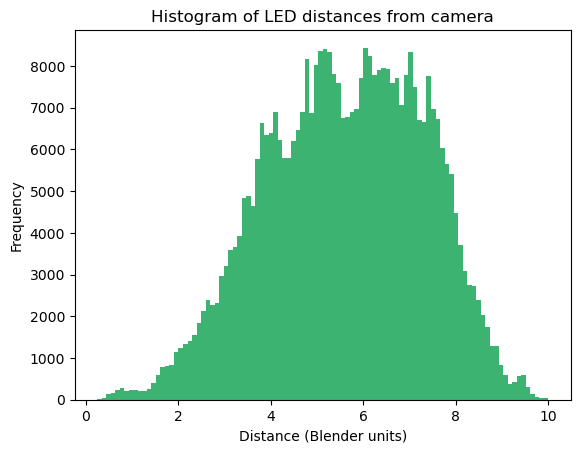

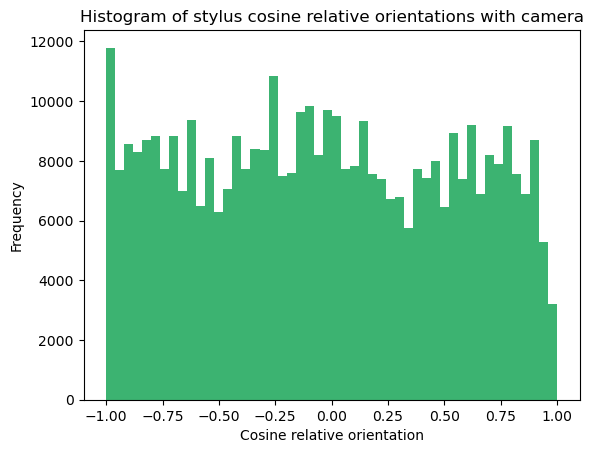

In [12]:
distances = []
stylus_relative_orientations = []
for led_data in led_data_iterator(show_progress=True):
    distance_from_camera = led_data["distance_from_camera"]
    stylus_relative_orientation = led_data["stylus_relative_orientation"]
    distances.append(distance_from_camera)
    stylus_relative_orientations.append(stylus_relative_orientation)

# Distance histogram
plt.figure()
plt.hist(distances, bins=100, color="mediumseagreen")
plt.title("Histogram of LED distances from camera")
plt.xlabel("Distance (Blender units)")
plt.ylabel("Frequency")
plt.show()

# Stylus relative orientation histogram
plt.figure()
plt.hist(stylus_relative_orientations, bins=50, color="mediumseagreen")
plt.title("Histogram of stylus cosine relative orientations with camera")
plt.xlabel("Cosine relative orientation")
plt.ylabel("Frequency")
plt.show()

Iterating over render folders: 100%|██████████| 288/288 [00:04<00:00, 70.36it/s]


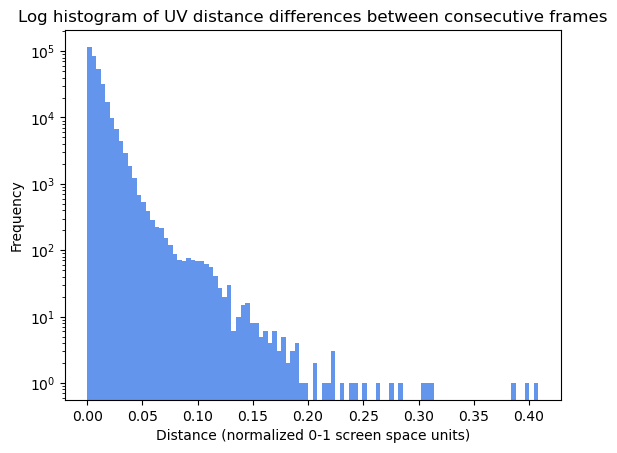

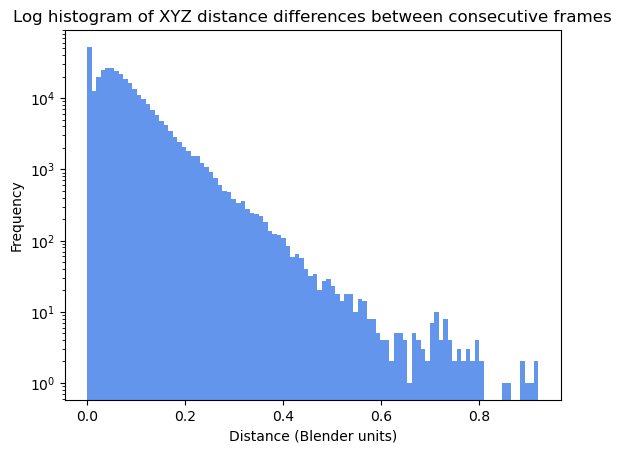

In [13]:
uv_distance_diffs = []
xyz_distance_diffs = []
for data in data_iterator(show_progress=True):
    previous_frame_data = None
    for frame_data in data.values():
        if previous_frame_data is None:
            previous_frame_data = frame_data["leds"]
            continue

        for led_id, led_data in frame_data["leds"].items():
            previous_led_data = previous_frame_data[led_id]
            u, prev_u = led_data["u"], previous_led_data["u"]
            v, prev_v = led_data["v"], previous_led_data["v"]
            x, prev_x = led_data["x"], previous_led_data["x"]
            y, prev_y = led_data["y"], previous_led_data["y"]
            z, prev_z = led_data["z"], previous_led_data["z"]
            is_in_frame = bool(led_data["is_in_frame"])

            if not is_in_frame:
                continue

            uv_distance_diff = np.linalg.norm([u - prev_u, v - prev_v])
            xyz_distance_diff = np.linalg.norm([x - prev_x, y - prev_y, z - prev_z])
            uv_distance_diffs.append(uv_distance_diff)
            xyz_distance_diffs.append(xyz_distance_diff)

        previous_frame_data = frame_data["leds"]

# UV distance histogram
plt.figure()
plt.hist(uv_distance_diffs, bins=100, color="cornflowerblue")
plt.title("Log histogram of UV distance differences between consecutive frames")
plt.xlabel("Distance (normalized 0-1 screen space units)")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

# XYZ distance histogram
plt.figure()
plt.hist(xyz_distance_diffs, bins=100, color="cornflowerblue")
plt.title("Log histogram of XYZ distance differences between consecutive frames")
plt.xlabel("Distance (Blender units)")
plt.ylabel("Frequency")
plt.yscale('log')
plt.show()

Iterating over render folders: 100%|██████████| 288/288 [00:01<00:00, 173.63it/s]


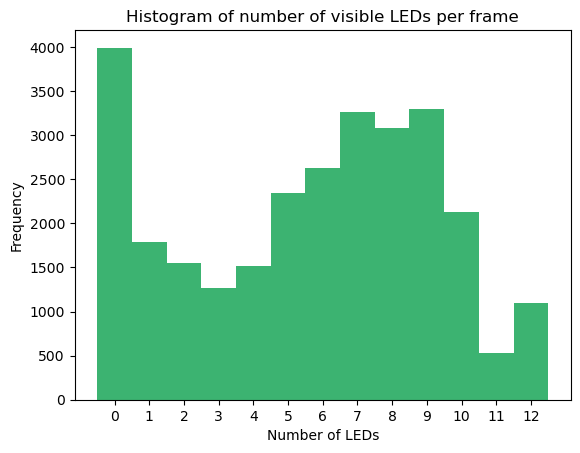

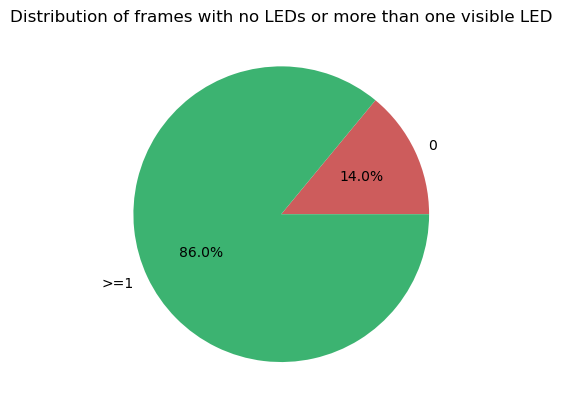

In [14]:
# Get histogram of n_LEDS that are not occluded and not out of frame
n_leds_per_frame = []
for frame_data in frame_data_iterator(show_progress=True):
    n_leds = sum(
        1 for led_data in frame_data["leds"].values()
        if not led_data["is_occluded"] and led_data["is_in_frame"]
    )
    n_leds_per_frame.append(n_leds)
    
# Separate in 0 and more than 1 as camembert
n_leds_0 = sum(1 for n_leds in n_leds_per_frame if n_leds == 0)
n_leds_more_than_1 = sum(1 for n_leds in n_leds_per_frame if n_leds >= 1)
    
# Histogram of n_LEDS that are not occluded and not out of frame
max_leds = max(n_leds_per_frame)
bin_edges = [x - 0.5 for x in range(max_leds + 2)]
plt.figure()
plt.hist(n_leds_per_frame, bins=bin_edges, color="mediumseagreen")
plt.title("Histogram of number of visible LEDs per frame")
plt.xlabel("Number of LEDs")
plt.ylabel("Frequency")
plt.xticks(range(max_leds + 1))  # Ensure x-axis labels are integers
plt.show()

# Pie chart of n_LEDS that are not occluded and not out of frame
plt.figure()
plt.pie([n_leds_0, n_leds_more_than_1], labels=["0", ">=1"], autopct="%1.1f%%", colors=["indianred", "mediumseagreen"])
plt.title("Distribution of frames with no LEDs or more than one visible LED")
plt.show()